<a href="https://colab.research.google.com/github/ErbolTakhirov/Learning-notebooks/blob/main/pandas/df_lecture_fillna_duplicates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRO


### Работа с пропущенными значениями в Data Science: за пределами `dropna()` и `fillna()`

В реальных задачах пропущенные значения (**missing values**) — это скорее норма, чем исключение. Они могут появляться по множеству причин: ошибки ввода, неполные анкеты, сбои в логировании, особенности поведения пользователей. И прежде чем строить модель, нужно **осознанно подойти к их обработке**, потому что способ, которым вы заполняете или удаляете пропуски, напрямую влияет на результаты анализа и качество моделей машинного обучения.

---

## ❓ Почему пропущенные значения — это важно

Пропущенные данные — это **не просто пустоты**. Часто они **содержат смысл**. Примеры:

- Пропущенное значение дохода может означать «не захотел указывать».
- Пропущенное время транзакции — возможно, транзакция не была завершена.
- Отсутствие рейтинга — пользователь не взаимодействовал с продуктом.

Слепое применение `dropna()` или `fillna()` может **уничтожить полезную информацию** или **исказить распределение** признаков.

---

## 🧹 Базовые методы

### `dropna()`

Удаляет строки с пропущенными значениями. Простой и часто применяемый метод.

**Плюсы:**
- Удаляет "грязные" данные.
- Не вносит предположений.

**Минусы:**
- Потеря информации.
- Потенциальный **sampling bias** — если данные не случайно пропущены (not **Missing Completely at Random**, MCAR).

---

### `fillna()` с фиксированными значениями

Часто заполняют:

- Нулями: `df['feature'].fillna(0)`
- Средним: `df['feature'].fillna(df['feature'].mean())`
- Медианой: `fillna(df['feature'].median())`
- Модой (для категориальных): `fillna(df['feature'].mode()[0])`

**Что может пойти не так?**

- **Искажение распределения**: заполнение средним делает его "островом стабильности", в реальности редко встречающимся.
- **Смазывание зависимости**: может "сгладить" корреляции.
- **Изменение дисперсии**: особенно опасно при `fillna(0)`.

---

## 🎯 Более продвинутые стратегии

### Заполнение по группам (`groupby`-based imputation)

Вместо глобального среднего можно заполнять, например, средним **в пределах категории**:

```python
df['income'] = df.groupby('region')['income'].transform(
    lambda x: x.fillna(x.mean())
)
```

**Преимущество**: сохраняется **внутригрупповая структура**, распределение менее искажается.

---

### Заполнение с помощью модели (ML-based imputation)

Если признак `feature_A` пропущен, можно обучить модель предсказания `feature_A` на остальных признаках (`feature_B`, `feature_C`, ...) и заполнить значения **предсказаниями**.

- Простые модели: `LinearRegression`, `KNNImputer`, `RandomForestRegressor`.
- Готовые пайплайны: `IterativeImputer` из `sklearn.impute`.

```python
from sklearn.impute import IterativeImputer
imp = IterativeImputer()
df_imputed = imp.fit_transform(df)
```

**Плюсы:**
- Учитывает взаимосвязи между признаками.
- Потенциально более точные оценки.

**Минусы:**
- Дольше по времени.
- Риск **data leakage**, если неправильно организовать пайплайн.

---

### Создание индикаторов пропуска (missing indicators)

Добавляется бинарный признак: был ли пропуск в этом поле.

```python
df['feature_is_null'] = df['feature'].isnull().astype(int)
```

Полезно, когда **факт пропуска сам по себе информативен**.

---

## 📌 Резюме: Не все пропуски равны

Перед тем как заполнять или удалять:

1. Пойми, **почему** значение пропущено. Это **MCAR**, **MAR** или **MNAR**?
2. Оцени, как повлияет заполнение на **распределение** и **взаимосвязи**.
3. Подумай о **сохранении информации**: не всё нужно заполнять, иногда пропуск — это важный сигнал.

---

## 🚀 Впереди

Давайте посмотрим все это на практике! GO.....

# Theoretical part

Сгенерим датафрейм для изучения функций:


*   `as_type()`

*   `fillna()`

*   `dropna()`
*   `duplicated()`


*   `drop_duplicates()`






## Создадим датасет

Датасет будет состоять из 1500 строк:

In [ ]:
N_ROWS = 1500

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Создадим три количественные фичи датафрейма. Также в некоторые колонки искусственно добавим пропуски с указанным процентом. Нам понадобятся следующие функции:

* `np.random.randint(from, to, num)` - функция, которая создает последовательность случайных числел в указанном первыми двумя аргументами диапазоне в указанном третьим аргументом количестве. Распределение равномерное!
* `np.random.randn(shape)` - создает массив данных указанной формы (многомерный массив или вектор) со стандартизированным Гаусовым распределением.
* `np.random.choice(array, size, p=list)` - позволяет выбрать из массива `array` или списка значения случайным образом в указанном количестве аргументом `size`. Также для каждого элемента можно указать вероятность появления значения аргументом `p`. В нашем примере мы так будем создавать бинарный массив.

In [ ]:
col_1 = np.random.randint(1, 20, N_ROWS).astype(str)
col_2 = np.random.randint(10, 100, N_ROWS)
col_3 = np.random.randn(N_ROWS)*5
null_mask_1 = np.random.choice([0, 1], size=N_ROWS, p=[0.8, 0.2]).astype(bool) # маски для замены значения пропуском
null_mask_2 = np.random.choice([0, 1], size=N_ROWS, p=[0.2, 0.8]).astype(bool)
null_mask_3 = np.random.choice([0, 1], size=N_ROWS, p=[0.6, 0.4]).astype(bool)

In [ ]:
df = pd.DataFrame({'A':col_1,
                   'B':col_2,
                   'C':col_3})
df.loc[null_mask_1, 'A'] = np.nan
df.loc[null_mask_2, 'B'] = np.nan
df.loc[null_mask_3, 'C'] = np.nan

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1224 non-null   object 
 1   B       308 non-null    float64
 2   C       942 non-null    float64
dtypes: float64(2), object(1)
memory usage: 35.3+ KB


Coздадим одну категориальную (номинативную) фичу с уникальными значениями `foo`, `bar`, `baz`. Так мы создадим в данных три группы.

In [ ]:
cat = ['foo', 'bar', 'baz']
cat_feature = np.random.choice(cat, size=N_ROWS, p=[0.3, 0.3, 0.4])
df['D'] = cat_feature

<Axes: xlabel='count', ylabel='D'>

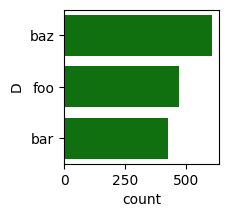

In [ ]:
plt.subplots(figsize=(2, 2))
sns.barplot(x=df.value_counts('D'), y=df.value_counts('D').index, color='green')

Подчеркнем различия по группам для колонки `C`:
* значения для `bar` увеличим на 10
* значения для `baz` уменьшим на 15

In [ ]:
df.loc[df.D == 'bar', 'C'] += 10
df.loc[df.D == 'baz', 'C'] += -15

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1224 non-null   object 
 1   B       308 non-null    float64
 2   C       942 non-null    float64
 3   D       1500 non-null   object 
dtypes: float64(2), object(2)
memory usage: 47.0+ KB


In [ ]:
df.dtypes

,0
A,object
B,float64
C,float64
D,object


In [ ]:
df.head()

,A,B,C,D
0,6,NaN,NaN,baz
1,11,NaN,-5.004964,foo
2,NaN,65.0,10.585312,bar
3,10,NaN,NaN,bar
4,NaN,NaN,NaN,baz


Оформим весь этот код как функцию:

In [ ]:
def get_data(N_ROWS:int)->pd.DataFrame:
  col_1 = np.random.randint(1, 20, N_ROWS).astype(str)
  col_2 = np.random.randint(10, 100, N_ROWS)
  col_3 = np.random.randn(N_ROWS)*5
  null_mask_1 = np.random.choice([0, 1], size=N_ROWS, p=[0.8, 0.2]).astype(bool) # маски для замены значения пропуском
  null_mask_2 = np.random.choice([0, 1], size=N_ROWS, p=[0.2, 0.8]).astype(bool)
  null_mask_3 = np.random.choice([0, 1], size=N_ROWS, p=[0.6, 0.4]).astype(bool)
  df = pd.DataFrame({'A':col_1,
                    'B':col_2,
                    'C':col_3})
  df.loc[null_mask_1, 'A'] = np.nan
  df.loc[null_mask_2, 'B'] = np.nan
  df.loc[null_mask_3, 'C'] = np.nan
  cat = ['foo', 'bar', 'baz']
  cat_feature = np.random.choice(cat, size=N_ROWS, p=[0.3, 0.3, 0.4])
  df['D'] = cat_feature
  df.loc[df.D == 'bar', 'C'] += 10
  df.loc[df.D == 'baz', 'C'] += -15
  return df

# Заполнение пропусков
`fillna()` - заполняет пропуски указанным значением.

## Заполнение пропусков в колонке `A`

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1198 non-null   object 
 1   B       307 non-null    float64
 2   C       902 non-null    float64
 3   D       1500 non-null   object 
dtypes: float64(2), object(2)
memory usage: 47.0+ KB


In [ ]:
df.head(3)

,A,B,C,D
0,3,NaN,NaN,foo
1,17,NaN,NaN,baz
2,11,NaN,10.519221,bar


In [ ]:
df.D.value_counts()

,count
D,
baz,596
foo,456
bar,448


In [ ]:
df.A.fillna(0)

,A
0,3
1,17
2,11
3,7
4,18
...,...
1495,13
1496,7
1497,0
1498,10


Заполнит пропуски нулем, однако тип данных не изменится.
Более адекватно будет заполнить пропуски каким либо значением, например средним или медианным. Однако, в этом случае необходимо изменить тип данных на числовой.

In [ ]:
df.A.fillna(0).astype(int)

,A
0,3
1,17
2,11
3,7
4,18
...,...
1495,13
1496,7
1497,0
1498,10


Проблемка... Объект `NaN` - имеет тип `float`, поэтому мы не можем сделать тип всей колонки целочисленным. Заменим тип на `float`:

In [ ]:
df.A = df.A.astype(float)

Оценим распределение в колонке `A`:

In [ ]:
df.A = df.A.fillna(0)

<Axes: xlabel='A', ylabel='Density'>

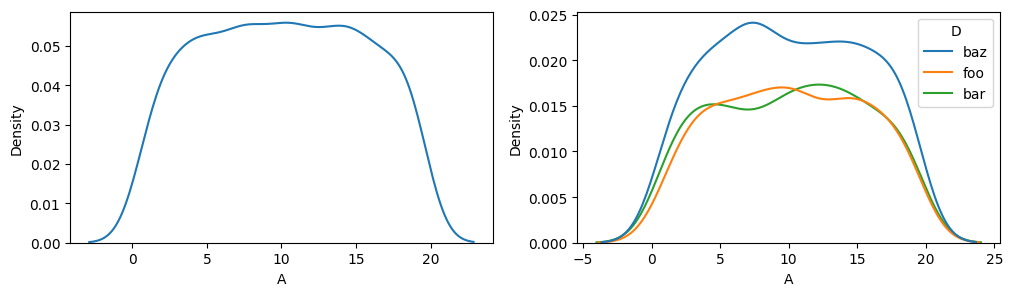

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
sns.kdeplot(data=df, x='A', ax = ax[0])
sns.kdeplot(data=df, x='A', hue='D', ax = ax[1])

Картина характерная для равномерного распределения.

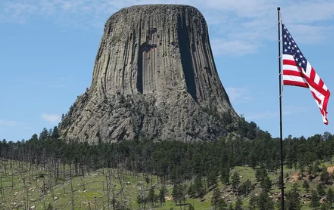

Заполним пропуски средним:

In [ ]:
print(f'Mean by "A" column is {df.A.mean().round(2)}.')
df.A.fillna(df.A.mean().round(2), inplace=True)

Mean by "A" column is 10.14.


/tmp/ipython-input-2614772462.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.A.fillna(df.A.mean().round(2), inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1500 non-null   float64
 1   B       316 non-null    float64
 2   C       896 non-null    float64
 3   D       1500 non-null   object 
dtypes: float64(3), object(1)
memory usage: 47.0+ KB


Посмотрим на итоговое распределение:

<Axes: xlabel='A', ylabel='Density'>

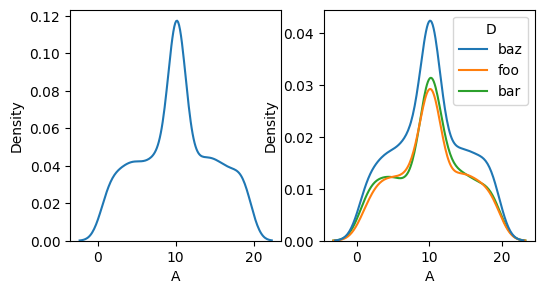

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.kdeplot(data=df, x='A', ax = ax[0])
sns.kdeplot(data=df, x='A', hue='D', ax = ax[1])

Мы сломали распределение... Почему? Какой вывод можно сделать?

## Сделаем заполнение колонки `C`

Однако, сперва оценим распределение.

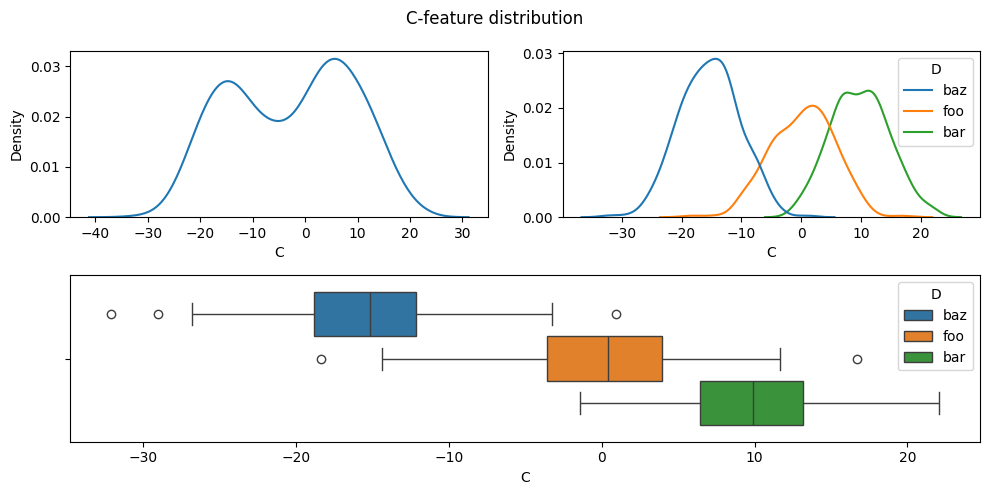

In [ ]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.kdeplot(data=df, x='C', ax=ax1)
sns.kdeplot(data=df, x='C', hue='D', ax=ax2)
sns.boxplot(data=df, x='C', hue='D', ax=ax3)

plt.suptitle('C-feature distribution')
plt.tight_layout()
plt.show()

Видим, что в этом признаке наблюдения явно зависят от значения группирующей переменной (фичи) `D`. Видится логичным заполнить средним не по всей колонке а средними по каждой группе. Получим эти средние:

In [ ]:
df.D.unique()

array(['baz', 'foo', 'bar'], dtype=object)

In [ ]:
mean_dict = {i:df.loc[df.D == i, 'C'].mean().round(2).item() for i in df.D.unique()}
mean_dict

{'baz': -15.3, 'foo': 0.25, 'bar': 9.83}

Однако как эти значения "засунуть" в fillnа()?
Сформируем соразмерную датафрейму серию:

In [ ]:
df.D.map(mean_dict).value_counts()

,count
D,
-15.30,619
9.83,452
0.25,429


Теперь мы для заполнения можем брать эту серию. Для каждого NaN будет подтянуто значение по соответствующему индексу из серии со средними значениями.

In [ ]:
df.C.fillna(df.D.map(mean_dict))

,C
0,-15.300000
1,8.558295
2,7.148440
3,1.889214
4,0.250000
...,...
1495,9.830000
1496,2.095578
1497,-22.845103
1498,-15.300000


Оценим результат:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1500 non-null   float64
 1   B       307 non-null    float64
 2   C       1500 non-null   float64
 3   D       1500 non-null   object 
dtypes: float64(3), object(1)
memory usage: 47.0+ KB


<Axes: xlabel='C', ylabel='Density'>

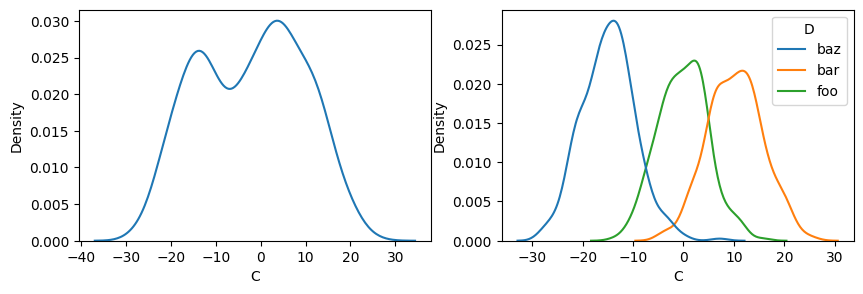

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(data=df, x='C', ax = ax[0])
sns.kdeplot(data=df, x='C', hue='D', ax = ax[1])

Результат удовлетворительный. Однако колонку `B` мы так заполнять не будем. Почему?

In [ ]:
df.B.value_counts(), df.A.value_counts(), df.C.value_counts()

(B
 44.0    10
 30.0     8
 68.0     6
 85.0     6
 86.0     6
         ..
 28.0     1
 52.0     1
 72.0     1
 42.0     1
 43.0     1
 Name: count, Length: 87, dtype: int64,
 A
 10.14    302
 10.00     73
 8.00      73
 14.00     71
 19.00     70
 7.00      68
 11.00     68
 15.00     66
 5.00      66
 4.00      66
 13.00     63
 12.00     63
 16.00     62
 6.00      58
 2.00      57
 9.00      57
 3.00      56
 17.00     56
 18.00     55
 1.00      50
 Name: count, dtype: int64,
 C
 -15.300000    266
  0.250000     169
  9.830000     163
  7.869985       1
 -14.570880      1
              ... 
 -7.433078       1
  17.211276      1
  8.380303       1
  1.702454       1
 -4.128659       1
 Name: count, Length: 905, dtype: int64)

<Axes: xlabel='B', ylabel='Density'>

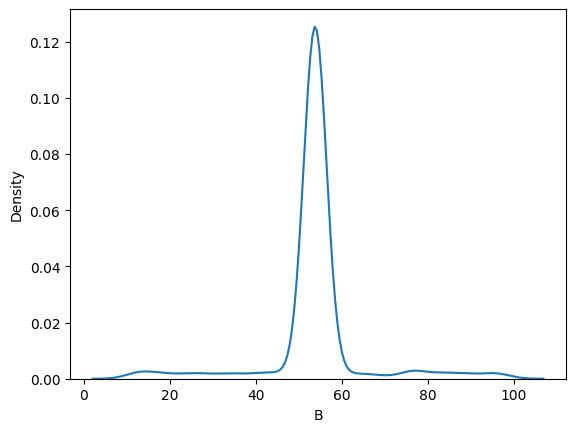

In [ ]:
sns.kdeplot(df.B.fillna(df.B.mean()))

## `dropna()`

Функция удаления строк или столбцов где есть пропуски. По дефолту она удалит строки, где есть хотя бы один пропуск. Если указать `axis=1`, то будут удалены столбцы, где есть хоть один пропуск. Чтобы не быть столь радикальными, рассмотрим параметры:

* `axis` = 0/1 - по строкам или столбцам
* `how`='all' - удалит только те строки (столбцы) где все значения пропущены
* `thresh` = 4 - порог. Указывает, сколько минимум должно быть непустых значений. Если непустых значений меньше, то строка (столбец) удаляется.
* `subset` = [...] - список колонок, с которыми работает функция.
* `inplace` - no comments)))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1500 non-null   float64
 1   B       302 non-null    float64
 2   C       1500 non-null   float64
 3   D       1500 non-null   object 
dtypes: float64(3), object(1)
memory usage: 47.0+ KB


У нас осталась одна колонка с пропусками. Давайте оценим степень ее заполненности.

In [ ]:
part = (df.B.notnull().sum() / df.shape[0] * 100).round()
print(f'Колонка заполнена на {part} %.')

Колонка заполнена на 19.0 %.


Очень распространена практика, когда колонка, которая заполнена менее чем на 30% удаляется. Давайте удалим все колонки, которые заполнены менее чем на 30%: (с целью научиться писать код для общего случая)

In [ ]:
min_num_val = int(round(df.shape[0]*.3))
min_num_val # столько должно быть минимум непустых значений в столбце для 30% порога

450

In [ ]:
df.dropna(thresh=min_num_val, axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1190 non-null   object 
 1   C       903 non-null    float64
 2   D       1500 non-null   object 
dtypes: float64(1), object(2)
memory usage: 35.3+ KB




```
# Выбран кодовый формат
```

Поработаем со строками. Сгенерим заново датасет.

In [ ]:
df = get_data(1500)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1190 non-null   object 
 1   B       293 non-null    float64
 2   C       943 non-null    float64
 3   D       1500 non-null   object 
dtypes: float64(2), object(2)
memory usage: 47.0+ KB


Посмотрим, сколько в каждой строке пропусков

In [ ]:
df.isnull().sum(axis=1).describe()[['mean', 'min', 'max']]

,0
mean,1.382667
min,0.000000
max,3.000000


Видим, что есть строки, где все три количественных значений пропущены. (Скорее всего так будет). Удалим те строки, где есть больше чем один пропуск. Тогда в строке должно остаться минимум 3 непустых значений.

In [ ]:
df.dropna(axis=0, thresh=3, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 877 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       845 non-null    object 
 1   B       271 non-null    float64
 2   C       780 non-null    float64
 3   D       877 non-null    object 
dtypes: float64(2), object(2)
memory usage: 34.3+ KB


In [ ]:
n = 1000
pp = np.random.randn(n).round()
print(f'Из 1000 чисел {pp[pp * 21 == 21].shape[0] / n * 100} % будут примерно равны одному')

Из 1000 чисел 23.5 % будут примерно равны одному


In [ ]:
df.isnull().sum(axis=1).describe()[['mean', 'min', 'max']]

,0
mean,0.850642
min,0.000000
max,1.000000


## Вывод

Мы познакомились с некоторыми простейшими приемами работы с пропусками. Однако существуют более продвинутые подходы работы с ними. Мы всегда принимаем рашение, как заполнять или удалять пропуски, исходя из специфики данных. Мы обращаем внимание на распределение и на зависимость от других признаков. Нам нельзя нарушать существующие зависимости и также нежелательно просто удалять значения так как это приводит к потере ценных данных. Часто при заполнении пропусков прибегают, например, к предсказанию того, каково наиболее вероятно значение той ячейки, где имеется пропуск с точки зрения значений в других колонках. Для этого необходимо глубокое изучение данных, построение трендов, зависимостей итд...

## Duplicates

Давайте сформируем датафрейм с дупликатами и поработаем с ним.

In [ ]:
df = get_data(1000)
df = pd.concat([df, df.sample(100)], axis=0) # выборка из 100 случайных строк и добавление ее в конец
df = df.sort_index().reset_index(drop=True) # приведение индексов в порядок
df

,A,B,C,D
0,12,56.0,-18.732899,baz
1,18,NaN,NaN,bar
2,NaN,NaN,5.533375,foo
3,NaN,89.0,-0.033403,foo
4,NaN,NaN,NaN,baz
...,...,...,...,...
1095,13,NaN,NaN,baz
1096,7,NaN,NaN,foo
1097,12,NaN,NaN,foo
1098,15,77.0,-1.864809,foo


## `df.duplicated(col:str|list, keep='last'|'first'|False)`

Возвращает булевый массив, где `True` соответствует повтору.

* `keep` = 'first' - Будут указаны сами элементы, которые ниже имеют дупликаты.
* `keep` = 'last' - Будет показан последний дупликат для каждого элемента.
* `keep` = False - для каждого элемента True пометит и сам элемент, который имеет повтор и все повторы.

In [ ]:
df[df.duplicated()]#.sum() # столько строк, которые имеют повторы

,A,B,C,D
12,13,NaN,-12.183615,baz
14,NaN,NaN,NaN,baz
20,9,NaN,NaN,foo
21,9,NaN,NaN,foo
27,18,NaN,NaN,bar
...,...,...,...,...
1093,15,NaN,-23.321264,baz
1095,13,NaN,NaN,baz
1096,7,NaN,NaN,foo
1097,12,NaN,NaN,foo


In [ ]:
df.duplicated(keep = 'last').sum()

np.int64(355)

In [ ]:
df.duplicated(keep = 'first').sum()

np.int64(355)

In [ ]:
df.duplicated('D').sum()

1097

## `df.drop_duplicates(col:str|list, keep='last'|'first'|False, ...)`

In [ ]:
df.shape

(1100, 4)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(754, 4)

# Practical part

In [ ]:
#@title Create DataFrame
brend  = ['Kia', 'Hyundai']
model = ['Rio', 'Solaris']
mod_dict = {'Kia': 'Rio', 'Hyundai': 'Solaris'}
production_year = np.random.randint(2017, 2023, 400)
bin = np.random.randint(0, 2, 400)
br_col = [brend[i] for i in bin]
engine_type = [[1.4, 1.6][i] for i in bin]
engine_type = [[1.4, 1.6][i] for i in bin]
transmission = [['Auto', 'Manual'][i] for i in bin]

df = pd.DataFrame()
df['brend'] = br_col
df['model'] = df.brend.map(mod_dict)
df['production_year'] = production_year
df['mileage'] = df.production_year.map(lambda i: np.random.randint((2023-i)*10000, (2023-i)*50000, 1)[0].astype(str) + ' km')
df['engine_type'] = engine_type
df['transmission'] = transmission
df['USD_price'] = df.production_year.map(lambda i: np.random.randint(16000*(1 - (2023-i)*0.15), 15000*(1 - (2023-i)*0.05), 1)[0])
df.loc[df['engine_type']==1.4, 'USD_price'] *= 0.93
df.loc[df['transmission']=='Manual', 'USD_price'] *= 0.95
df.loc[df['transmission']=='Manual', 'USD_price'] *= 0.95
df['mileage_int'] = df.mileage.map(lambda i: int(i.replace(' km', '')))
df.loc[df['mileage_int'] > 100000, 'USD_price'] *= 0.88
df.loc[df['mileage_int'] > 150000, 'USD_price'] *= 0.92
df.loc[np.random.randint(0, 401, 5).tolist(), 'production_year'] = np.nan
df.loc[np.random.randint(0, 401, 5).tolist(), 'mileage'] = np.nan
df.drop('mileage_int', axis=1, inplace=True)
df = pd.concat([df, df.sample(100)], axis=0)
df = df.sort_index().reset_index(drop=True)

/tmp/ipython-input-3022915339.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[11133.96  9307.44 11637.09 10960.05 12285.3   5095.47  5659.05 10743.36
 10200.24  7745.04  8228.64 12747.51  2128.77 13112.07 13008.84 10544.34
 12369.    9208.86  7121.01  5064.78  4895.52 12797.73  3805.56  9356.73
 10219.77  6620.67  9247.92 10254.18  7271.67 13130.67 12089.07 11795.19
  9162.36 13196.7  11852.85 12850.74 13180.89  7364.67 10146.3   3986.91
 12887.01 10448.55 12825.63 13130.67 11019.57  6275.64  8099.37 10888.44
 10777.77 11392.5   5073.15  2874.63  7939.41  2155.74 11057.7   4376.58
  6860.61 13010.7   3593.52 11695.68 11824.02 12676.83  7304.22 11040.96
  9157.71  7407.45 11168.37  4060.38 12738.21  6263.55  5490.72 13026.51
  8591.34  7301.43  9525.06  8190.51  4798.8  13176.24 10095.15  8175.63
  8091.   11443.65  8585.76  9594.81 10092.36 10238.37  2165.97  3906.
 10505.28  9708.27  3469.83  8721

In [ ]:
df

,brend,model,production_year,mileage,engine_type,transmission,USD_price
0,Hyundai,Solaris,2021.0,56796 km,1.6,Manual,10978.010000
1,Hyundai,Solaris,2020.0,132496 km,1.6,Manual,7283.608200
2,Hyundai,Solaris,2017.0,289684 km,1.6,Manual,7472.500728
3,Kia,Rio,2020.0,49286 km,1.4,Auto,10758.240000
4,Hyundai,Solaris,2022.0,49447 km,1.6,Manual,12837.160000
...,...,...,...,...,...,...,...
495,Kia,Rio,2019.0,50332 km,1.4,Auto,6955.470000
496,Hyundai,Solaris,2022.0,33331 km,1.6,Manual,12348.005000
497,Hyundai,Solaris,2018.0,212594 km,1.6,Manual,3645.282696
498,Hyundai,Solaris,2018.0,212594 km,1.6,Manual,3645.282696


## Task_1

Мы сгенерили датасет, посвященный продажам известных марок авто.

Давайте его изучим, посмотрим пропуски, типы данных в колонках и те колонки, которые можно сделать числовыми сделаем таковыми. Удалим дупликаты!!!

In [ ]:
df__ = df.copy()

In [ ]:
df.dtypes

,0
brend,object
model,object
production_year,float64
mileage,object
engine_type,float64
transmission,object
USD_price,float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brend            500 non-null    object 
 1   model            500 non-null    object 
 2   production_year  494 non-null    float64
 3   mileage          493 non-null    object 
 4   engine_type      500 non-null    float64
 5   transmission     500 non-null    object 
 6   USD_price        500 non-null    float64
dtypes: float64(3), object(4)
memory usage: 27.5+ KB


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
def dun(s):
  if isinstance(s, str):
    spl = s.split()
    if len(spl) > 1:
      return float(spl[0])
    else:
      return float(s)
  else:
    return float(s)

In [ ]:
df.production_year = df.production_year.map(dun)

In [ ]:
df.production_year

,production_year
0,2017.0
1,2018.0
2,2021.0
3,2021.0
4,2020.0
...,...
495,2019.0
496,2022.0
497,2017.0
498,2018.0


In [ ]:
df.production_year.value_counts()

,count
production_year,
2018.0,109
2020.0,98
2021.0,85
2017.0,76
2022.0,65
2019.0,62


In [ ]:
df.head()

,brend,model,production_year,mileage,engine_type,transmission,USD_price
0,Hyundai,Solaris,2018,164299 km,1.6,Manual,7178.773800
1,Kia,Rio,2017,283588 km,1.4,Auto,1996.012128
2,Kia,Rio,2021,32324 km,1.4,Auto,11257.650000
3,Kia,Rio,2017,259895 km,1.4,Auto,1544.255328
4,Hyundai,Solaris,2017,225857 km,1.6,Manual,4819.459744


In [ ]:
df.mileage = df.mileage.map(dun)

In [ ]:
df.mileage

,mileage
0,80877.0
1,108980.0
2,57285.0
3,32679.0
4,81019.0
...,...
495,109011.0
496,25343.0
497,143307.0
498,129918.0


In [ ]:
df.dtypes

,0
brend,object
model,object
production_year,float64
mileage,float64
engine_type,float64
transmission,object
USD_price,float64


## Task_2

Давайте проверим, есть ли тут строки, где встречается 2 раза NaN. Если такие строки есть, дропнeм их.

In [ ]:
df.dropna(thresh = df.shape[0] - 2, axis = 0, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brend            400 non-null    object 
 1   model            400 non-null    object 
 2   production_year  395 non-null    float64
 3   mileage          395 non-null    float64
 4   engine_type      400 non-null    float64
 5   transmission     400 non-null    object 
 6   USD_price        400 non-null    float64
dtypes: float64(4), object(3)
memory usage: 25.0+ KB


In [ ]:
df.loc[(df.production_year == np.nan)& (df.mileage == np.nan)]

,brend,model,production_year,mileage,engine_type,transmission,USD_price


## Task_3

Давайте создадим колонку со средней стоимостью авто по годам выпуска.

И колонку со средним пробегом по годам выпуска.

Покажите на графике средние пробеги и средние стоимости по годам выпуска.

In [ ]:
mean_d = {i: df.loc[df.production_year == i, 'mileage'].mean() for i in df.production_year.unique()}
mean_d_2 = {i: df.loc[df.production_year == i, 'USD_price'].mean() for i in df.production_year.unique()}
df['mileage_per_year'] = np.nan
df.mileage_per_year.fillna(df.production_year.map(mean_d), inplace = True)
df['price_per_year'] = np.nan
df.price_per_year.fillna(df.production_year.map(mean_d_2), inplace = True)

/tmp/ipython-input-3516712895.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.mileage_per_year.fillna(df.production_year.map(mean_d), inplace = True)
/tmp/ipython-input-3516712895.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [ ]:
df

,brend,model,production_year,mileage,engine_type,transmission,USD_price,mileage_per_year,price_per_year
0,Kia,Rio,2019.0,111946.0,1.4,Auto,9012.2208,122620.555556,7365.312912
1,Kia,Rio,2022.0,29934.0,1.4,Auto,13169.7300,32924.093333,12727.641645
2,Kia,Rio,2022.0,29934.0,1.4,Auto,13169.7300,32924.093333,12727.641645
3,Hyundai,Solaris,2020.0,88617.0,1.6,Manual,11301.1050,86938.176471,9208.435974
4,Hyundai,Solaris,2020.0,129525.0,1.6,Manual,8467.7604,86938.176471,9208.435974
...,...,...,...,...,...,...,...,...,...
495,Kia,Rio,2021.0,96764.0,1.4,Auto,12241.5900,60853.357143,11301.669048
496,Hyundai,Solaris,2017.0,63233.0,1.6,Manual,5741.7050,168398.181818,4650.214626
497,Hyundai,Solaris,2022.0,15215.0,1.6,Manual,12377.7875,32924.093333,12727.641645
498,Hyundai,Solaris,2022.0,15215.0,1.6,Manual,12377.7875,32924.093333,12727.641645


In [ ]:
df.columns

Index(['brend', 'model', 'production_year', 'mileage', 'engine_type',
       'transmission', 'USD_price'],
      dtype='object')

In [ ]:
df.production_year

,production_year
0,2019.0
1,2022.0
2,2022.0
3,2020.0
4,2020.0
...,...
495,2021.0
496,2017.0
497,2022.0
498,2022.0


In [ ]:
df['mileage'] = df.mileage.str.replace(' km', '').astype(float)

<Axes: xlabel='production_year', ylabel='price_per_year'>

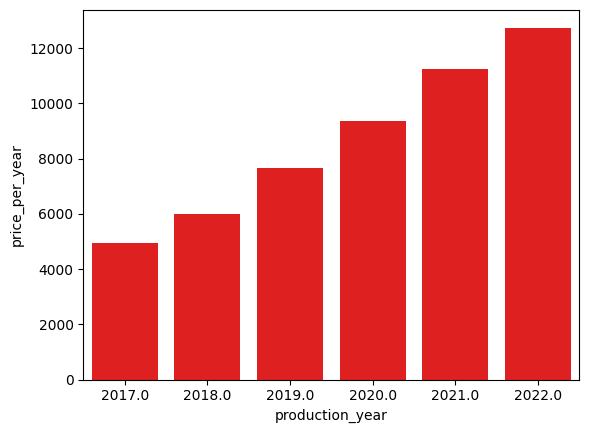

In [ ]:
sns.barplot(x = df.production_year,y = df.price_per_year, color = 'red')

<Axes: xlabel='production_year', ylabel='mileage_per_year'>

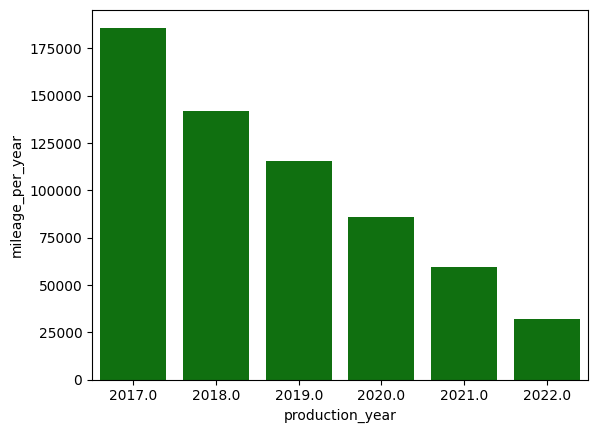

In [ ]:
sns.barplot(x = df.production_year, y = df.mileage_per_year, color = 'green')

In [ ]:
display(np.std(df.USD_price), np.max(df.USD_price), np.min(df.USD_price), np.mean(df.USD_price).item())

3208.4653179086

13251.570000000002

1454.2968

8428.837034336

## Task_4

Наша задача по-умному заполнить пропуски в колонке "Пробег".. Если мы просто заполним средними то это может сломать зависимость между ценой и пробегом, а она по логике вещей существенна.

У нас есть средние пробега и и стоимости по годам. Нужно заполнить пропуски значением около среднего с учетом года выпуска но так, чтобы пробег был больше среднего, если цена ниже среднего и нгаоборот. Давайте подумаем, как это сделать...

In [ ]:
df.columns

Index(['brend', 'model', 'production_year', 'mileage', 'engine_type',
       'transmission', 'USD_price', 'mileage_per_year', 'price_per_year'],
      dtype='object')

In [ ]:
df.describe()

,production_year,mileage,engine_type,USD_price,mileage_per_year,price_per_year
count,492.000000,493.000000,500.000000,500.000000,492.000000,492.000000
mean,2019.487805,106941.592292,1.500400,8428.837034,107114.303958,8467.056605
std,1.684315,68690.965707,0.100099,3211.678604,50812.551352,2857.337688
min,2017.000000,11766.000000,1.400000,1454.296800,32924.093333,4650.214626
25%,2018.000000,48249.000000,1.400000,5929.987272,60853.357143,5687.278627
50%,2020.000000,92035.000000,1.600000,8346.734132,86938.176471,9208.435974
75%,2021.000000,151376.000000,1.600000,11343.296875,168398.181818,11301.669048
max,2022.000000,298584.000000,1.600000,13251.570000,168626.060241,12727.641645


In [ ]:
# def dun(df, m):


In [ ]:
k_price = -(df.USD_price - df.price_per_year)/df.price_per_year
k_price.head()

,0
0,-0.509343
1,-0.307367
2,-0.307367
3,0.061356
4,-0.042738


In [ ]:
m_pred = df.mileage_per_year * (1 - k_price)
m_pred.head()

,0
0,199174.344565
1,198267.508973
2,198267.508973
3,142349.297244
4,60860.887697


In [ ]:
df.mileage.head()

,mileage
0,111946.0
1,29934.0
2,29934.0
3,88617.0
4,129525.0


Text(0.5, 1.0, 'Predicted mileage')

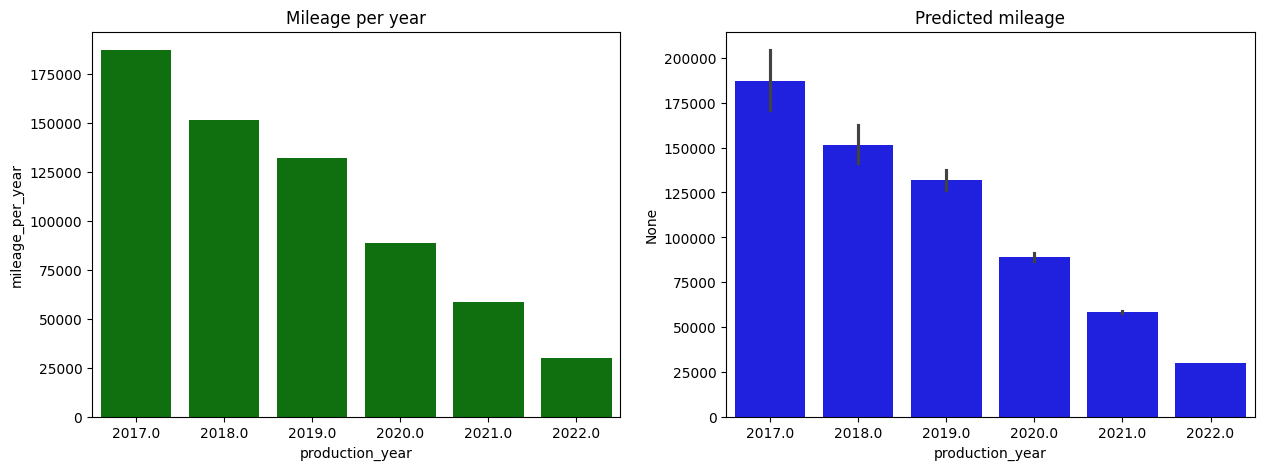

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Первый график
sns.barplot(x=df.production_year, y=df.mileage_per_year, color='green', ax=ax[0])
ax[0].set_title('Mileage per year')

# Второй график
sns.barplot(x=df.production_year, y=m_pred, color='blue', ax=ax[1])
ax[1].set_title('Predicted mileage')

In [ ]:
df.mileage_per_year[df.mileage_per_year - m_pred > 100000]

,mileage_per_year
25,187386.448276
120,187386.448276
199,187386.448276
200,187386.448276
206,187386.448276
261,187386.448276
262,187386.448276
421,187386.448276
422,187386.448276
478,187386.448276


In [ ]:
k_mileage = -(df.mileage - df.mileage_per_year)/df.mileage_per_year
k_mileage.head()

,0
0,0.577231
1,-0.565226
3,0.179838
4,-0.134539
6,0.507457


In [ ]:
m_pred_ = df.price_per_year * (1 - k_mileage)
m_pred_.head()

,0
0,3118.637070
1,9021.536554
3,4727.191964
4,12661.604059
6,5496.848238


# kde

<Axes: ylabel='Density'>

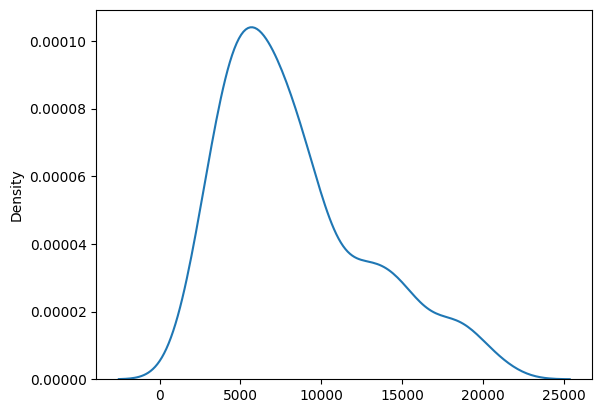

In [ ]:
sns.kdeplot(m_pred_)

<Axes: xlabel='mileage', ylabel='Density'>

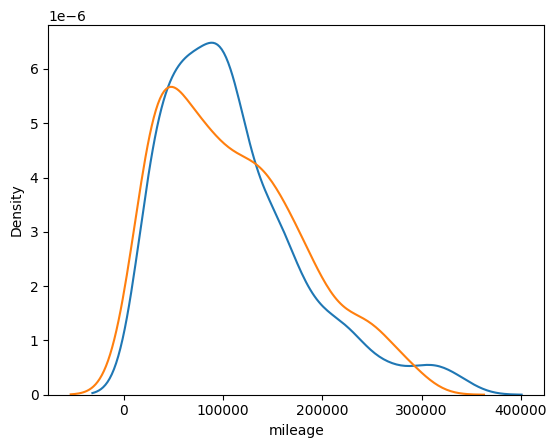

In [ ]:
sns.kdeplot(m_pred)
sns.kdeplot(df.mileage)

<Axes: ylabel='Density'>

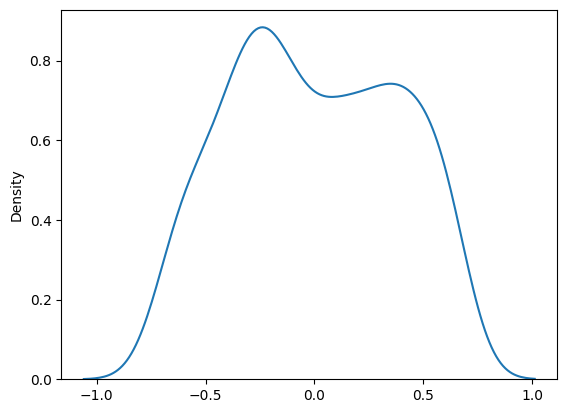

In [ ]:
sns.kdeplot(k_mileage)

<Axes: xlabel='mileage', ylabel='Density'>

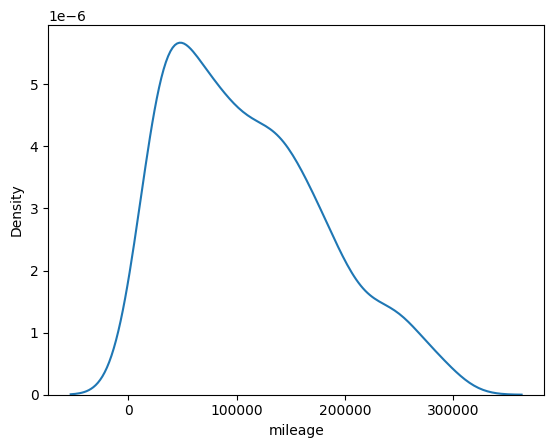

In [ ]:
sns.kdeplot(df.mileage)

<Axes: xlabel='USD_price', ylabel='Density'>

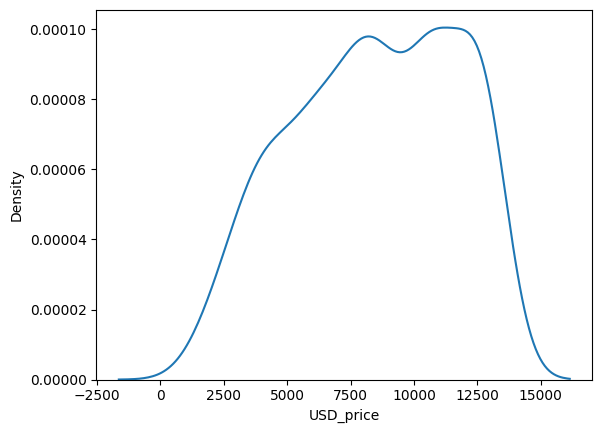

In [ ]:
sns.kdeplot(df.USD_price)

In [ ]:
len(k_mileage[k_mileage - k_price < -1])

8

In [ ]:
df.fillna({'mileage' : m_pred}, inplace = True)

In [ ]:
df

,brend,model,production_year,mileage,engine_type,transmission,USD_price,mileage_per_year,price_per_year
0,Kia,Rio,2019.0,111946.000000,1.4,Auto,9012.220800,122620.555556,7365.312912
1,Kia,Rio,2022.0,29934.000000,1.4,Auto,13169.730000,32924.093333,12727.641645
3,Hyundai,Solaris,2020.0,88617.000000,1.6,Manual,11301.105000,86938.176471,9208.435974
4,Hyundai,Solaris,2020.0,129525.000000,1.6,Manual,8467.760400,86938.176471,9208.435974
5,Kia,Rio,2017.0,187363.000000,1.4,Auto,6756.775872,168398.181818,4650.214626
...,...,...,...,...,...,...,...,...,...
493,Hyundai,Solaris,2021.0,56574.000000,1.6,Manual,11081.797500,60853.357143,11301.669048
494,Kia,Rio,2021.0,96764.000000,1.4,Auto,12241.590000,60853.357143,11301.669048
496,Hyundai,Solaris,2017.0,63233.000000,1.6,Manual,5741.705000,168398.181818,4650.214626
497,Hyundai,Solaris,2022.0,15215.000000,1.6,Manual,12377.787500,32924.093333,12727.641645


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brend             400 non-null    object 
 1   model             400 non-null    object 
 2   production_year   395 non-null    float64
 3   mileage           400 non-null    float64
 4   engine_type       400 non-null    float64
 5   transmission      400 non-null    object 
 6   USD_price         400 non-null    float64
 7   mileage_per_year  395 non-null    float64
 8   price_per_year    395 non-null    float64
dtypes: float64(6), object(3)
memory usage: 31.2+ KB


In [ ]:
z = (df.mileage - df.mileage_per_year) / np.std(df.mileage_per_year)

In [ ]:
z_ = (df.USD_price - df.price_per_year) / np.std(df.price_per_year)

<Axes: xlabel='mileage', ylabel='USD_price'>

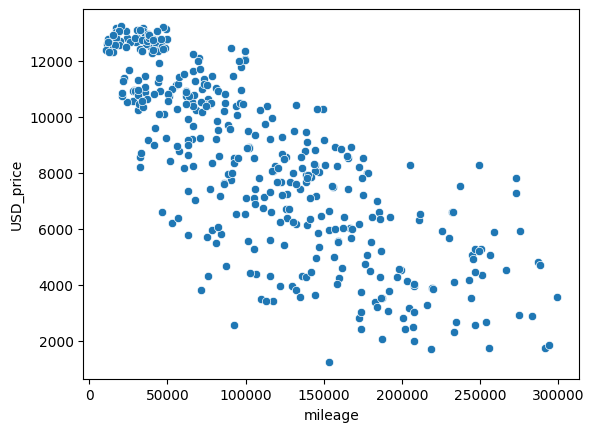

In [ ]:
sns.scatterplot(data = df, x = 'mileage', y = 'USD_price')

In [ ]:
df.drop_duplicates(inplace=True)

<Axes: ylabel='Density'>

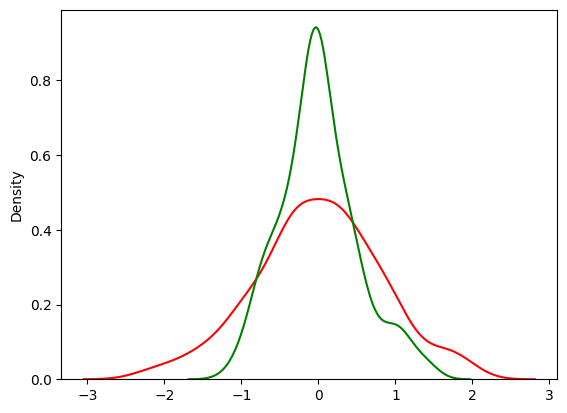

In [ ]:
sns.kdeplot(z, color = 'red')
sns.kdeplot(z_, color = 'green')

<Axes: ylabel='Density'>

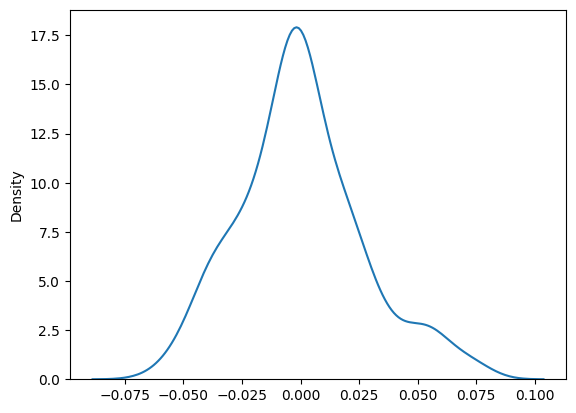

In [ ]:
sns.kdeplot(z_)

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
(abs((df.mileage - m_pred)/ df.mileage).sum())/df.shape[0]

np.float64(0.5584278479072968)

In [ ]:
error = np.abs(z_ - z) / z_.sum()    # Relative error per element
loss = error.sum() / df.shape[0]     # Mean over all elements

In [ ]:
loss

np.float64(0.5928478890570916)

In [ ]:
df.fillna({'mileage':m_pred}, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brend             400 non-null    object 
 1   model             400 non-null    object 
 2   production_year   395 non-null    float64
 3   mileage           400 non-null    float64
 4   engine_type       400 non-null    float64
 5   transmission      400 non-null    object 
 6   USD_price         400 non-null    float64
 7   mileage_per_year  395 non-null    float64
 8   price_per_year    395 non-null    float64
dtypes: float64(6), object(3)
memory usage: 31.2+ KB


<Axes: >

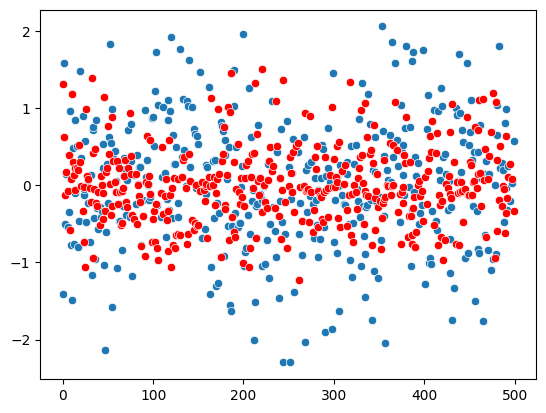

In [ ]:
sns.scatterplot(z)
sns.scatterplot(z_, color = 'red')


## Task_5

У нас таже присутствуют пропуски в колонке Год выпуска.

Давайте также как-то по-умному их заполним!) Должно получиться)

In [ ]:
df.production_year.unique()

array([2019., 2018., 2021., 2017., 2020., 2022.,   nan])

<Axes: xlabel='production_year', ylabel='USD_price'>

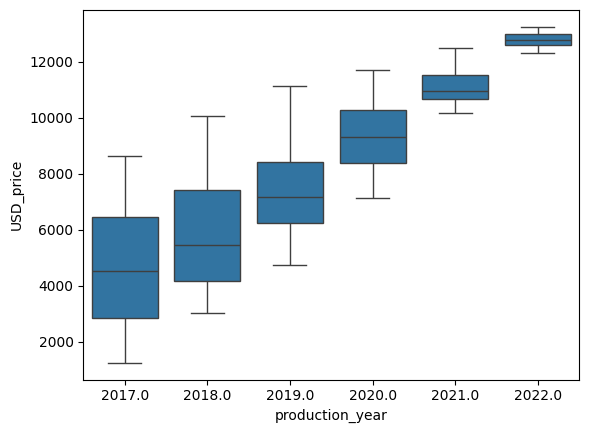

In [ ]:
sns.boxplot(x = df.production_year, y = df.USD_price)

<Axes: xlabel='production_year', ylabel='mileage'>

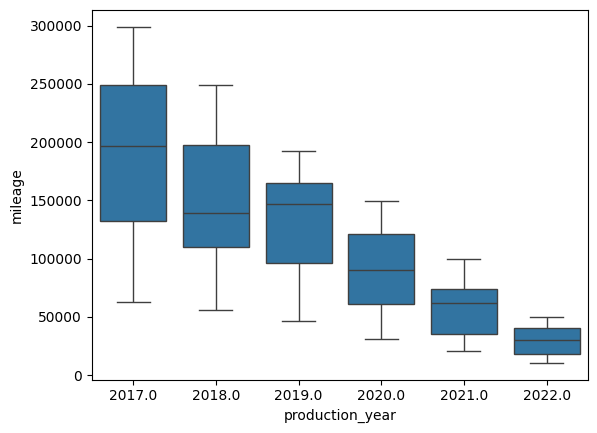

In [ ]:
sns.boxplot(x = df.production_year, y = df.mileage)

<Axes: xlabel='mileage', ylabel='production_year'>

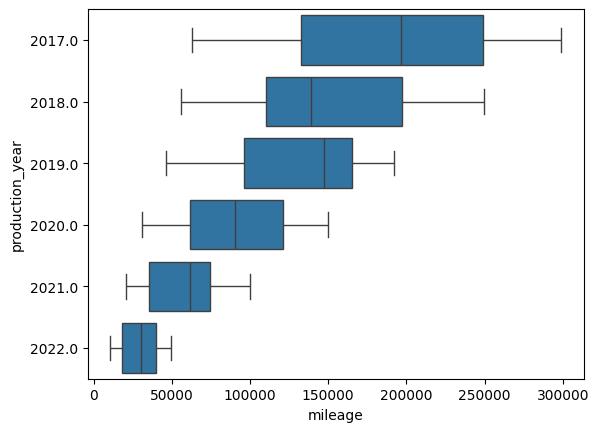

In [ ]:
sns.boxplot(y = df.production_year, x = df.mileage, orient = 'h')


In [ ]:
display(m_pred, df.mileage)

,0
0,199174.344565
1,198267.508973
2,198267.508973
3,142349.297244
4,60860.887697
...,...
495,146165.399615
496,146165.399615
497,91014.261320
498,91014.261320


,mileage
0,55789.0
1,237373.0
3,124381.0
4,66219.0
6,28748.0
...,...
492,12783.0
493,43569.0
495,120783.0
497,90294.0


In [ ]:
alpha = df.price_per_year / df.mileage_per_year

In [ ]:
alpha_ = df.USD_price / df.mileage

In [ ]:
alpha

,0
0,0.055901
1,0.038006
3,0.038006
4,0.191208
6,0.191208
...,...
492,0.427519
493,0.427519
495,0.055901
497,0.105031


In [ ]:
df['alpha'] = df.USD_price / df.mileage

In [ ]:
df

,brend,model,production_year,mileage,engine_type,transmission,USD_price,mileage_per_year,price_per_year,alpha
0,Kia,Rio,2019.0,55789.0,1.4,Auto,11133.960000,131960.987179,7376.694805,0.199573
1,Kia,Rio,2018.0,237373.0,1.4,Auto,7535.303424,151654.111111,5763.726738,0.031745
3,Hyundai,Solaris,2018.0,124381.0,1.6,Manual,5410.090400,151654.111111,5763.726738,0.043496
4,Kia,Rio,2021.0,66219.0,1.4,Auto,11637.090000,58366.450000,11160.133500,0.175736
6,Kia,Rio,2021.0,28748.0,1.4,Auto,10960.050000,58366.450000,11160.133500,0.381246
...,...,...,...,...,...,...,...,...,...,...
492,Hyundai,Solaris,2022.0,12783.0,1.6,Manual,12326.345000,29887.355263,12777.415190,0.964276
493,Kia,Rio,2022.0,43569.0,1.4,Auto,13076.730000,29887.355263,12777.415190,0.300138
495,Hyundai,Solaris,2019.0,120783.0,1.6,Manual,8170.729600,131960.987179,7376.694805,0.067648
497,Hyundai,Solaris,2020.0,90294.0,1.6,Manual,9559.280000,88929.605263,9340.327380,0.105868


<Axes: xlabel='production_year', ylabel='alpha'>

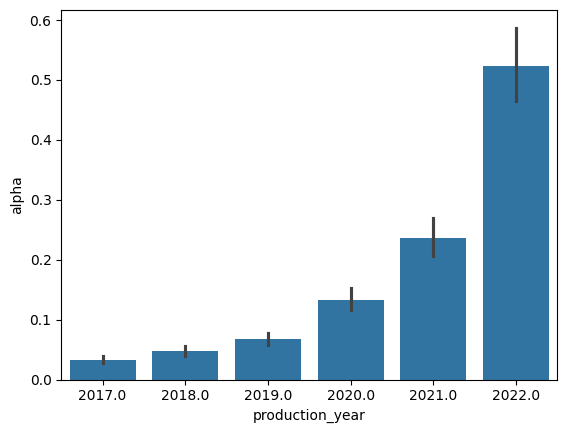

In [ ]:
sns.barplot(data = df, x = 'production_year', y = 'alpha')

<Axes: xlabel='alpha', ylabel='production_year'>

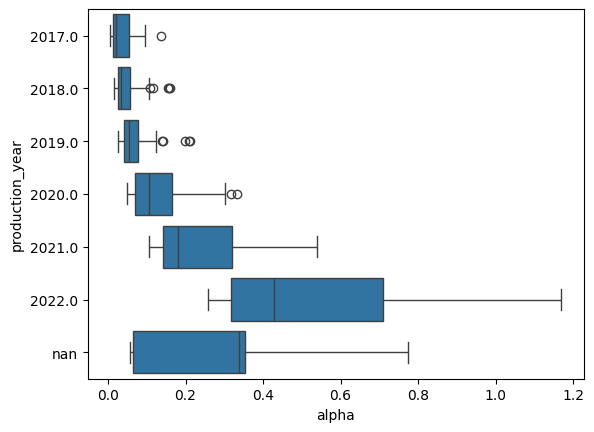

In [ ]:
sns.boxplot(data = df.sort_values(by = 'production_year'), y = df.sort_values(by = 'production_year').production_year.astype(str), x =df.sort_values(by = 'production_year').alpha )

In [ ]:
df['alpha_per_year'] = np.nan
mean_d = {i: df.loc[df['production_year'] == i, 'alpha'].mean() for i in df.production_year.unique()}
df.alpha_per_year.fillna(df.production_year.map(mean_d))

In [ ]:
mean_d = {i: df.loc[df['production_year'] == i, 'alpha'].mean() for i in df.production_year.unique()}

In [ ]:
mean_d

{np.float64(2019.0): np.float64(0.06739334485995145),
 np.float64(2018.0): np.float64(0.04744604729890303),
 np.float64(2021.0): np.float64(0.23702884442598962),
 np.float64(2017.0): np.float64(0.033038172710334324),
 np.float64(2020.0): np.float64(0.13357881669553115),
 np.float64(2022.0): np.float64(0.5227903289371448),
 np.float64(nan): nan}

In [ ]:
df['alpha_per_year'] = np.nan

In [ ]:
df.alpha_per_year.fillna(df.production_year.map(mean_d))

,alpha_per_year
0,0.067393
1,0.047446
3,0.047446
4,0.237029
6,0.237029
...,...
492,0.522790
493,0.522790
495,0.067393
497,0.133579


## Task_6

Давайте оценим, как в среднем много автомобиль проезжает за год независимо от типа двигателя и трансмиссии.

In [ ]:
for i in range(2017, 2023):
  df['alpha_' + str(i)] = df.loc[df.production_year == i ,'alpha'].mean()

In [ ]:
df

,brend,model,production_year,mileage,engine_type,transmission,USD_price,mileage_per_year,price_per_year,alpha,alpha_per_year,alpha_2017,alpha_2018,alpha_2019,alpha_2020,alpha_2021,alpha_2022
0,Kia,Rio,2019.0,55789.0,1.4,Auto,11133.960000,131960.987179,7376.694805,0.199573,NaN,0.033038,0.047446,0.067393,0.133579,0.237029,0.52279
1,Kia,Rio,2018.0,237373.0,1.4,Auto,7535.303424,151654.111111,5763.726738,0.031745,NaN,0.033038,0.047446,0.067393,0.133579,0.237029,0.52279
3,Hyundai,Solaris,2018.0,124381.0,1.6,Manual,5410.090400,151654.111111,5763.726738,0.043496,NaN,0.033038,0.047446,0.067393,0.133579,0.237029,0.52279
4,Kia,Rio,2021.0,66219.0,1.4,Auto,11637.090000,58366.450000,11160.133500,0.175736,NaN,0.033038,0.047446,0.067393,0.133579,0.237029,0.52279
6,Kia,Rio,2021.0,28748.0,1.4,Auto,10960.050000,58366.450000,11160.133500,0.381246,NaN,0.033038,0.047446,0.067393,0.133579,0.237029,0.52279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,Hyundai,Solaris,2022.0,12783.0,1.6,Manual,12326.345000,29887.355263,12777.415190,0.964276,NaN,0.033038,0.047446,0.067393,0.133579,0.237029,0.52279
493,Kia,Rio,2022.0,43569.0,1.4,Auto,13076.730000,29887.355263,12777.415190,0.300138,NaN,0.033038,0.047446,0.067393,0.133579,0.237029,0.52279
495,Hyundai,Solaris,2019.0,120783.0,1.6,Manual,8170.729600,131960.987179,7376.694805,0.067648,NaN,0.033038,0.047446,0.067393,0.133579,0.237029,0.52279
497,Hyundai,Solaris,2020.0,90294.0,1.6,Manual,9559.280000,88929.605263,9340.327380,0.105868,NaN,0.033038,0.047446,0.067393,0.133579,0.237029,0.52279


In [ ]:
df.armin(df.loc[df.isnull() == True, ])

In [ ]:
alpha = ['alpha_' + str(i) for i in range(2017, 2023)]

['alpha_2017',
 'alpha_2018',
 'alpha_2019',
 'alpha_2020',
 'alpha_2021',
 'alpha_2022']

In [ ]:
alphas = ['alpha_' + str(i) for i in range(2017, 2023)]

In [ ]:
alphas

['alpha_2017',
 'alpha_2018',
 'alpha_2019',
 'alpha_2020',
 'alpha_2021',
 'alpha_2022']

In [ ]:
index_ = df.production_year[df.production_year.isnull()].index

Index([80, 107, 142, 323, 469], dtype='int64')

In [ ]:
df[index_].production_year.fillna(np.argmin(df[i] for i in alphas if i == df[df.production_year.isnull().index]))[107]

np.float64(0.0)

In [ ]:
df.production_year.loc[80]

np.float64(nan)

In [ ]:
for i in sorted(df.production_year.dropna().unique()):
  year = int(i.item())
  df[f'{year}_alpha'] = abs(df.alpha - mean_d[year])

In [ ]:
year = df.iloc[:, -6:].idxmin(axis = 1)

In [ ]:
year_ser = year.map(lambda i: i.split('_')[0]).astype(int)

In [ ]:
year_ser

,0
0,2021
1,2017
3,2018
4,2020
6,2022
...,...
492,2022
493,2021
495,2019
497,2020


In [ ]:
df['year_pred'] = year_ser

In [ ]:
df.year_pred

,year_pred
0,2021
1,2017
3,2018
4,2020
6,2022
...,...
492,2022
493,2021
495,2019
497,2020


In [ ]:
df.fillna({'production_year':df.year_pred}, inplace=True)

In [ ]:
(df.production_year == df.year_pred).sum()/df.shape[0]

np.float64(0.3875)

In [ ]:
(df.production_year == df.pred_year).sum()/df.shape[0]

np.float64(0.0)

In [ ]:
(df.production_year == df.pred_year).sum()/df.shape[0]

np.float64(0.0)

In [ ]:
df['pred_year'] = predicted_year

In [ ]:
alphas = [f'alpha_{year}' for year in range(2017, 2023)]

mask = df['production_year'].isnull()

predicted_col = df.loc[mask, alphas].idxmax(axis=1)

predicted_year = predicted_col.str.extract(r'(\d{4})')[0].astype(int)

df.loc[mask, 'production_year'] = predicted_year.values

In [ ]:
df.pred_year

,pred_year
0,NaN
1,NaN
3,NaN
4,NaN
6,NaN
...,...
492,NaN
493,NaN
495,NaN
497,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 499
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brend             400 non-null    object 
 1   model             400 non-null    object 
 2   production_year   400 non-null    float64
 3   mileage           400 non-null    float64
 4   engine_type       400 non-null    float64
 5   transmission      400 non-null    object 
 6   USD_price         400 non-null    float64
 7   mileage_per_year  395 non-null    float64
 8   price_per_year    395 non-null    float64
 9   alpha             400 non-null    float64
 10  alpha_per_year    0 non-null      float64
 11  alpha_2017        400 non-null    float64
 12  alpha_2018        400 non-null    float64
 13  alpha_2019        400 non-null    float64
 14  alpha_2020        400 non-null    float64
 15  alpha_2021        400 non-null    float64
 16  alpha_2022        400 non-null    float64
 17  20

In [ ]:
pred_year = predicted_col[:4]

In [ ]:
df.loc[mask, 'production_year'] = predic_year.values

In [ ]:
df.production_year[107]

np.float64(2022.0)

In [ ]:
df.alpha()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 499
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brend             400 non-null    object 
 1   model             400 non-null    object 
 2   production_year   395 non-null    float64
 3   mileage           400 non-null    float64
 4   engine_type       400 non-null    float64
 5   transmission      400 non-null    object 
 6   USD_price         400 non-null    float64
 7   mileage_per_year  395 non-null    float64
 8   price_per_year    395 non-null    float64
 9   alpha             400 non-null    float64
 10  alpha_per_year    0 non-null      float64
 11  alpha_2017        400 non-null    float64
 12  alpha_2018        400 non-null    float64
 13  alpha_2019        400 non-null    float64
 14  alpha_2020        400 non-null    float64
 15  alpha_2021        400 non-null    float64
 16  alpha_2022        400 non-null    float64
dtypes:

<Axes: xlabel='mileage', ylabel='USD_price'>

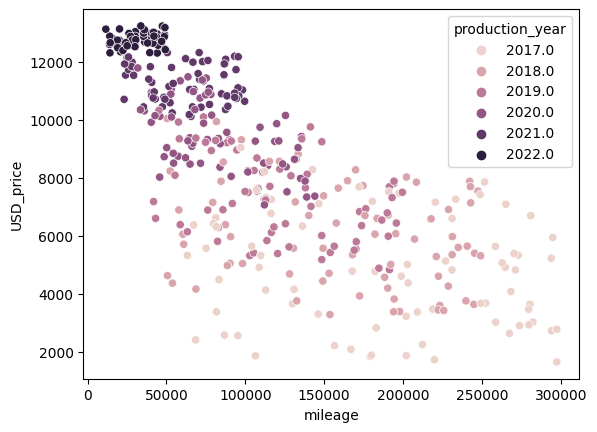

In [ ]:
sns.scatterplot(x='mileage', y = 'USD_price', data = df, hue='production_year')

<Axes: xlabel='production_year', ylabel='USD_price'>

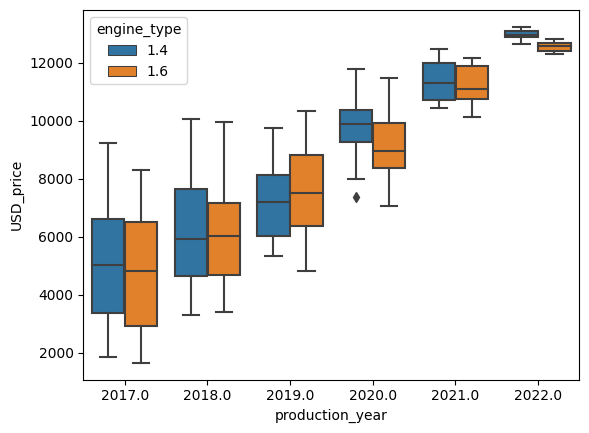

In [ ]:
sns.boxplot(y = df.USD_price, x=df.production_year, hue = df.engine_type)

In [ ]:
df.loc[df.USD_price == min(df.USD_price)]

,brend,model,production_year,mileage,engine_type,transmission,USD_price,mileage_per_year,price_per_year
371,Kia,Rio,2017.0,104395.0,1.4,Auto,1454.2968,168398.181818,4650.214626


In [ ]:
df.columns

Index(['brend', 'model', 'production_year', 'mileage', 'engine_type',
       'transmission', 'USD_price', 'mileage_per_year', 'price_per_year',
       'alpha', 'alpha_per_year', 'alpha_2017', 'alpha_2018', 'alpha_2019',
       'alpha_2020', 'alpha_2021', 'alpha_2022', '2017_alpha', '2018_alpha',
       '2019_alpha', '2020_alpha', '2021_alpha', '2022_alpha', 'year_pred',
       'pred_year'],
      dtype='object')

In [ ]:
df = df.reindex(columns = ['alpha', 'alpha_per_year', 'alpha_2017', 'alpha_2018', 'alpha_2019',
       'alpha_2020', 'alpha_2021', 'alpha_2022', '2017_alpha', '2018_alpha',
       '2019_alpha', '2020_alpha', '2021_alpha', '2022_alpha', 'year_pred',
       'pred_year'])

In [ ]:
df.production_year = df.production_year.astype(int)

AttributeError: 'DataFrame' object has no attribute 'production_year'

In [ ]:
df.USD_price = df.USD_price.round(2)

AttributeError: 'DataFrame' object has no attribute 'USD_price'

In [ ]:
df['name'] = df.brend + ' ' + df.model

AttributeError: 'DataFrame' object has no attribute 'brend'